In [336]:
import sys
sys.path.append("../../")
import warnings
warnings.simplefilter(action="ignore")
import numpy as np
import seaborn as sns
import pandas as pd
import polars as pl
import plotly.express as px
from functions.eda import *
from functions.cat_eda import *
from functions.num_eda import *
from functions.basic_cleaning import *
from functions.pipeline_helpers import *

In [337]:
train_data = pl.read_csv("train_data.csv").pipe(reduce_memory_usage)
test_data = pl.read_csv("test_data.csv").pipe(reduce_memory_usage)
train_data.shape,test_data.shape

((4907, 19), (2108, 19))

In [338]:
# train_data=train_data.with_columns(train_data["gender"].str.replace_many(["Male","Female"],["1","0"]).cast(pl.Int8))
# test_data=test_data.with_columns(test_data["gender"].str.replace_many(["Male","Female"],["1","0"]).cast(pl.Int8))

In [339]:
cat_cols=[col for col in train_data.drop("customerID").columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("Churn").columns if train_data[col].dtype!= pl.String]

In [340]:
for col in cat_cols[:-1]:
    train_data=train_data.with_columns(train_data[col].str.replace_many(["Yes","No"],["1","0"]).cast(pl.Int8))
    test_data=test_data.with_columns(test_data[col].str.replace_many(["Yes","No"],["1","0"]).cast(pl.Int8))

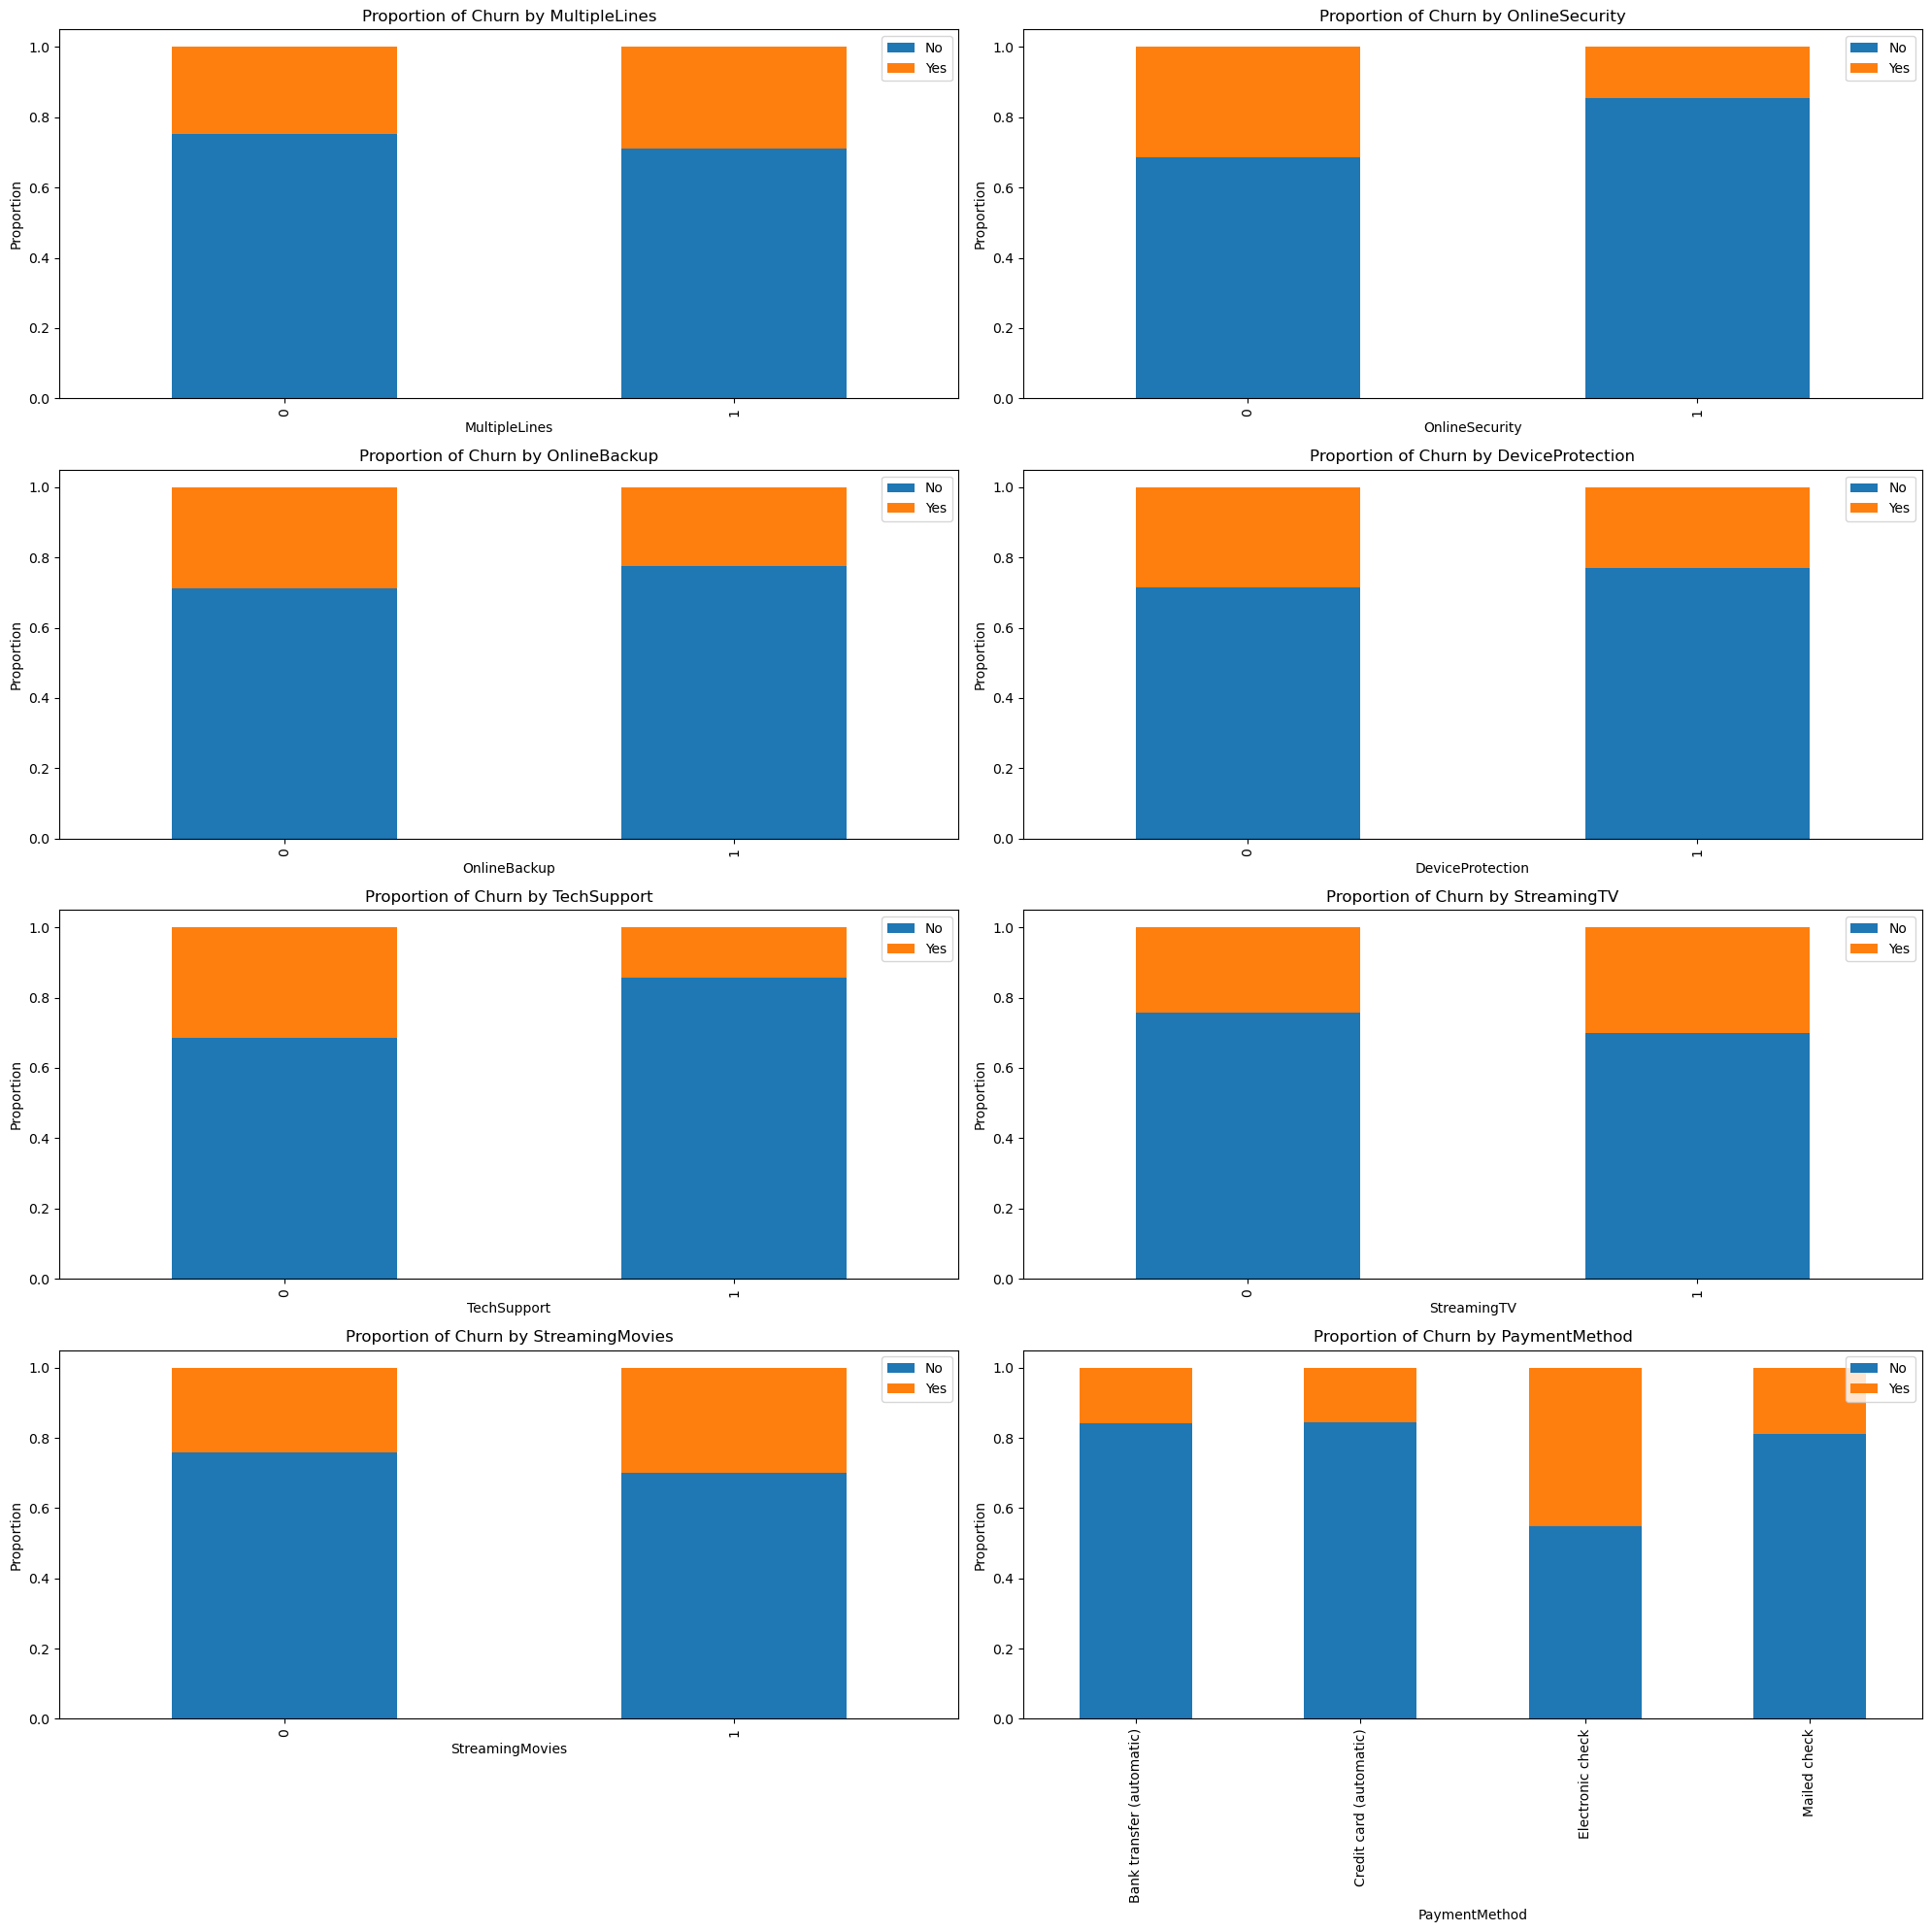

In [341]:
cat_proportion_plot(train_data,cat_cols,"Churn")

In [342]:
train_data=train_data.with_columns(train_data["PaymentMethod"].is_in(["Electronic check"]).cast(pl.Int8).alias("ElectricCheck")).drop("PaymentMethod")
test_data=test_data.with_columns(test_data["PaymentMethod"].is_in(["Electronic check"]).cast(pl.Int8).alias("ElectricCheck")).drop("PaymentMethod")

In [343]:
train_data=train_data.with_columns(pl.Series((train_data["StreamingMovies"] | train_data["StreamingTV"])).alias("StreamersWithTechSupport")).drop("StreamingMovies","StreamingTV")
train_data=train_data.with_columns(pl.Series(train_data["OnlineSecurity"] & train_data["DeviceProtection"] & train_data['OnlineBackup']).alias("Safer")).drop("OnlineSecurity","DeviceProtection","OnlineBackup")
train_data=train_data.with_columns(pl.Series(train_data['Partner'] & train_data['Dependents']).alias("Family")).drop("Partner","Dependents")
train_data=train_data.with_columns(pl.Series(train_data['PaperlessBilling'] & train_data["ElectricCheck"]).alias("OnlinePayment")).drop("PaperlessBilling","ElectricCheck")
train_data=train_data.with_columns(pl.Series(train_data["StreamersWithTechSupport"] & train_data["Safer"] & train_data['Family']).alias("All"))


test_data=test_data.with_columns(pl.Series((test_data["StreamingMovies"] | test_data["StreamingTV"])).alias("StreamersWithTechSupport")).drop("StreamingMovies","StreamingTV")
test_data=test_data.with_columns(pl.Series(test_data["OnlineSecurity"] & test_data["DeviceProtection"] & test_data['OnlineBackup']).alias("Safer")).drop("OnlineSecurity","DeviceProtection","OnlineBackup")
test_data=test_data.with_columns(pl.Series(test_data['Partner'] & test_data['Dependents']).alias("Family")).drop("Partner","Dependents")
test_data=test_data.with_columns(pl.Series(test_data['PaperlessBilling'] & test_data["ElectricCheck"]).alias("OnlinePayment")).drop("PaperlessBilling","ElectricCheck")
test_data=test_data.with_columns(pl.Series(test_data["StreamersWithTechSupport"] & test_data["Safer"] & test_data['Family']).alias("All"))

In [344]:
cat_cols=[col for col in train_data.drop("customerID").columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("Churn").columns if train_data[col].dtype!= pl.String]

Non Binary Features

In [345]:
non_binary_cols=[col for col in num_cols if len(train_data[col].unique())>2]
binary_cols=[col for col in num_cols if len(train_data[col].unique())==2]
non_binary_cols

['tenure', 'InternetService', 'Contract', 'MonthlyCharges', 'TotalCharges']

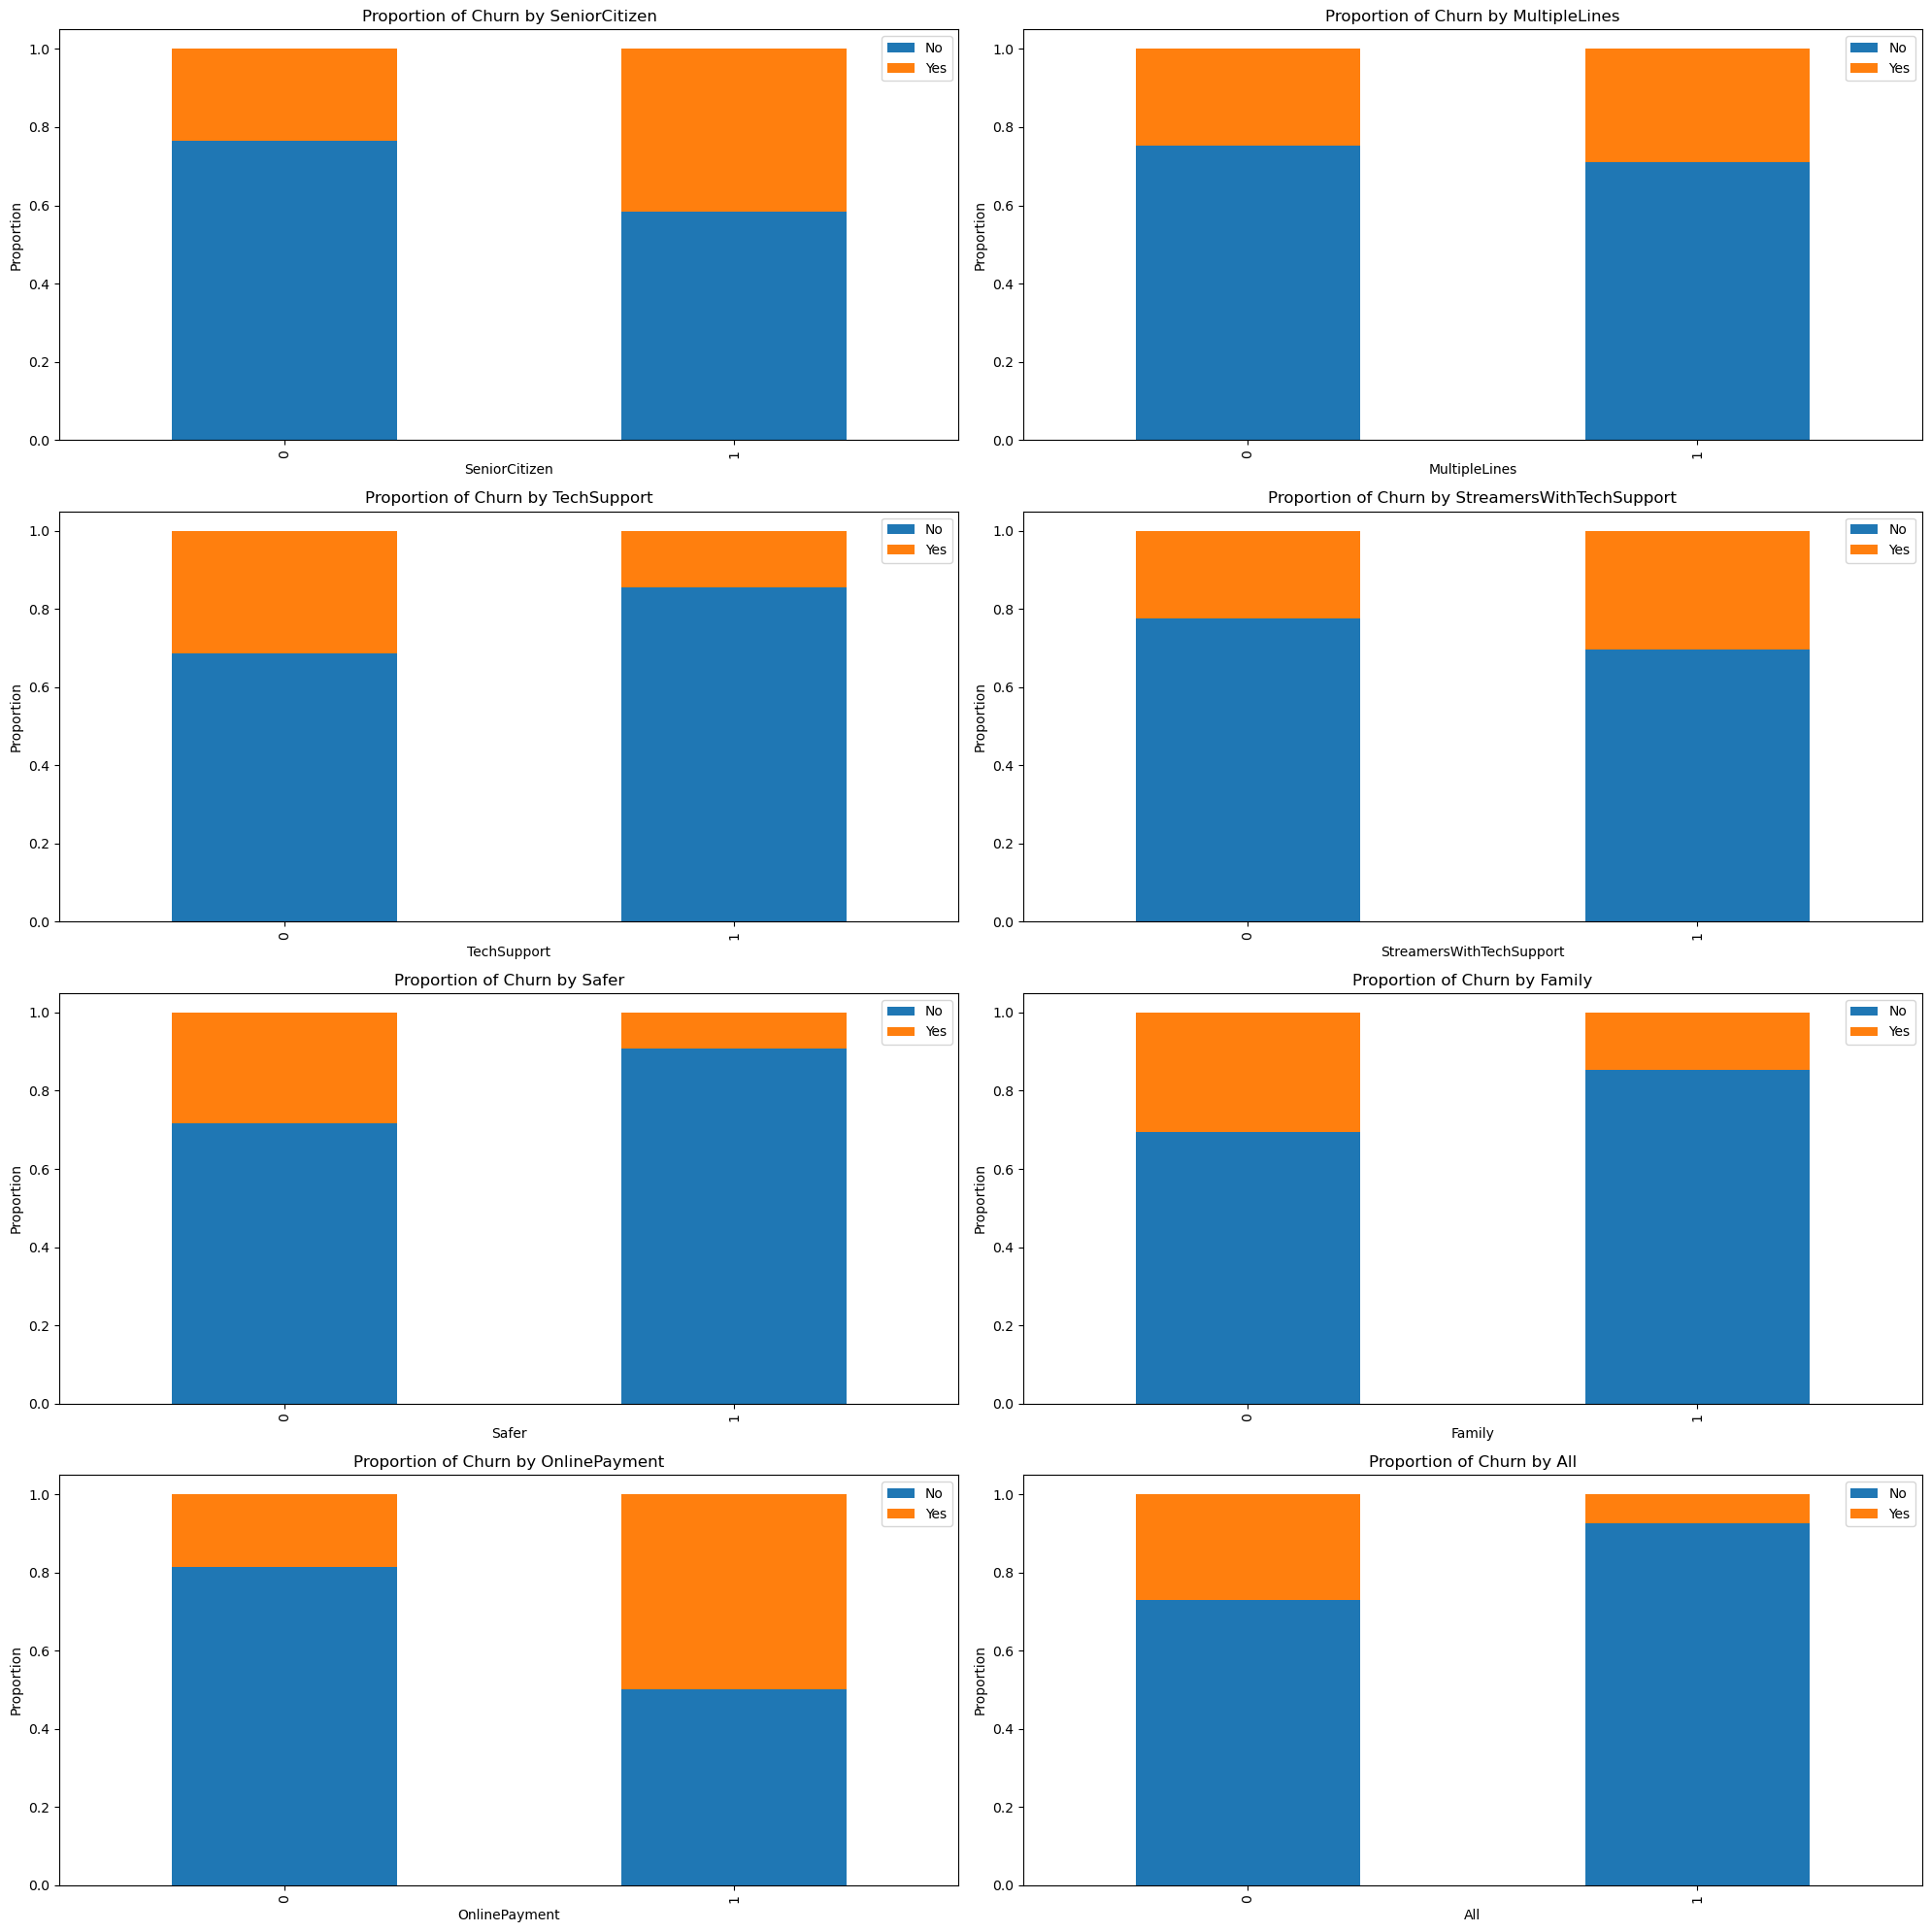

In [346]:
cat_proportion_plot(train_data,binary_cols,"Churn")

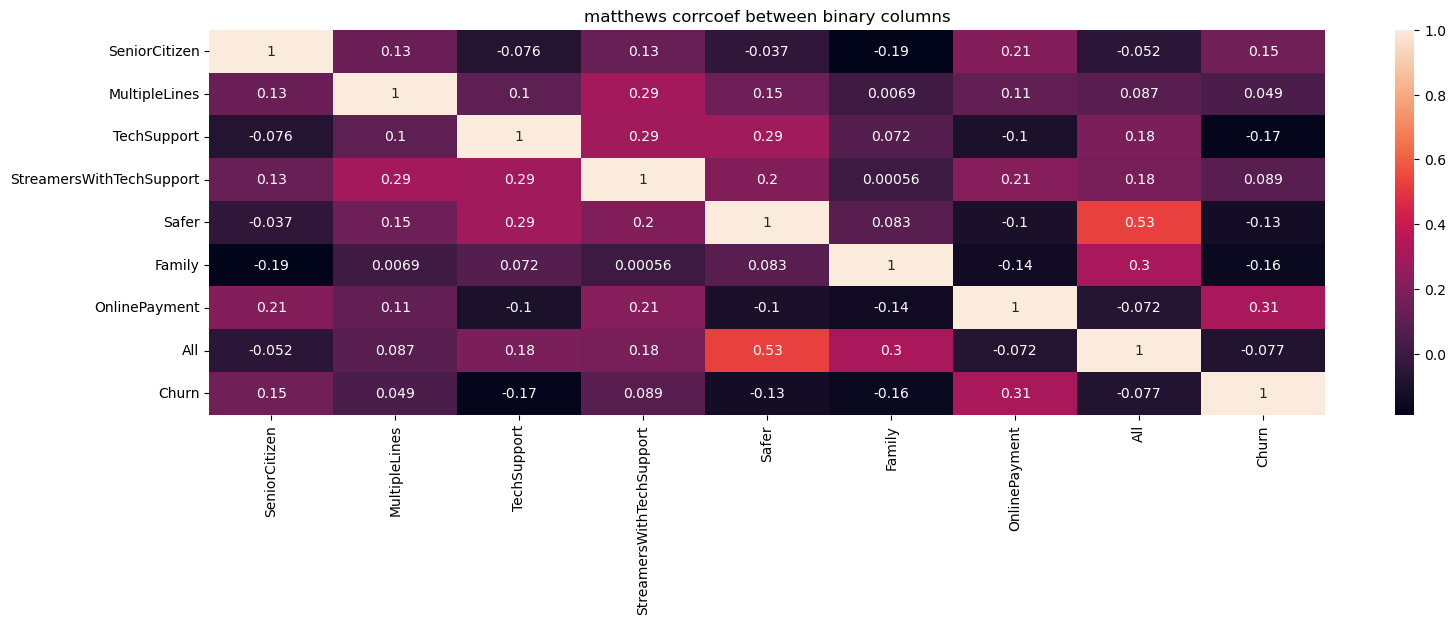

In [347]:
plot_binarycols_heatmap(train_data,binary_cols+["Churn"])

In [348]:
perform_non_normal_kruskal_hypothesis(train_data,binary_cols,"Churn")

Kruskal-Wallis H-statistic: 111.72166139262728 P-value: 4.1116574484464326e-26
There is a significant difference in Churn between different SeniorCitizen categories.

Kruskal-Wallis H-statistic: 11.540928244135756 P-value: 0.0006808063996668083
There is a significant difference in Churn between different MultipleLines categories.

Kruskal-Wallis H-statistic: 150.06129649919154 P-value: 1.6809770868271914e-34
There is a significant difference in Churn between different TechSupport categories.

Kruskal-Wallis H-statistic: 38.95900309287013 P-value: 4.3279968613058393e-10
There is a significant difference in Churn between different StreamersWithTechSupport categories.

Kruskal-Wallis H-statistic: 84.8463472349599 P-value: 3.2247600026971634e-20
There is a significant difference in Churn between different Safer categories.

Kruskal-Wallis H-statistic: 118.03725781722639 P-value: 1.701614564785628e-27
There is a significant difference in Churn between different Family categories.

Kruskal-W

In [349]:
# from sklearn.cluster import KMeans
# from sklearn.pipeline import Pipeline
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import StandardScaler,OneHotEncoder

# cat_cols=[col for col in train_data.drop("customerID").columns if train_data[col].dtype== pl.String]
# num_cols=[col for col in train_data.drop("Churn").columns if train_data[col].dtype!= pl.String]

# X_train=train_data.drop("customerID","Churn").to_pandas()
# y_train=train_data["Churn"].to_pandas()
# X_test=test_data.drop("customerID","Churn").to_pandas()
# y_test=test_data["Churn"].to_pandas()

# transformer = ColumnTransformer(
#     [
#         ("onehot", OneHotEncoder(handle_unknown="ignore",drop='first'), cat_cols),
#         ("scaler", StandardScaler(), num_cols)
#      ],
#     remainder="passthrough",
# )
# kmeans_pipe = Pipeline(
#     [
#         ("tranformer", transformer),
#         ("classifier", KMeans(n_clusters=3,random_state=42)),
#     ]
# )
# kmeans_pipe
# kmeans_pipe.fit(X_train)
# # Evaluation
# train_clusters=kmeans_pipe.predict(X_train)
# test_clusters=kmeans_pipe.predict(X_test)
# train_data=train_data.with_columns(pl.Series(train_clusters).alias("Cluster"))
# test_data=test_data.with_columns(pl.Series(test_clusters).alias("Cluster"))

# Multivariate Analysis

In [350]:
# sns.pairplot(train_data[non_binary_cols+["Cluster","Churn"]].to_pandas(),hue='Churn',y_vars="Cluster")

<Axes: xlabel='tenure', ylabel='TotalCharges'>

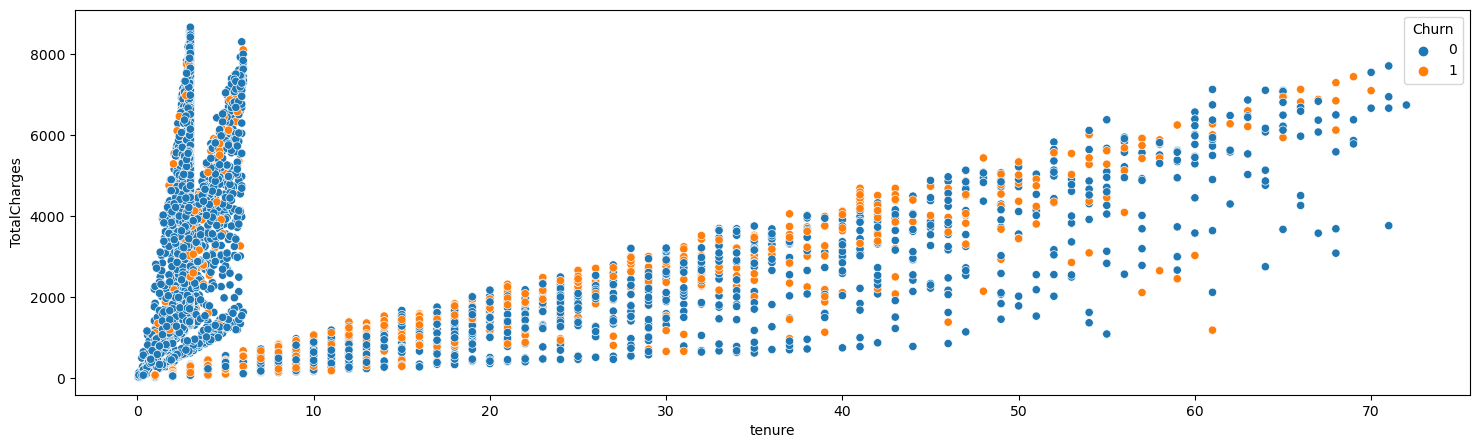

In [351]:
plt.figure(figsize=(18,5))
sns.scatterplot(train_data,x=train_data["tenure"]/train_data["Contract"],y="TotalCharges",hue='Churn')

In [352]:
train_data=train_data.with_columns(pl.Series(train_data["tenure"]/(train_data["Contract"])).alias("ExpectedRechargeTimes"))
test_data=test_data.with_columns(pl.Series(test_data["tenure"]/(test_data["Contract"])).alias("ExpectedRechargeTimes"))

<Axes: xlabel='MonthlyCharges', ylabel='Count'>

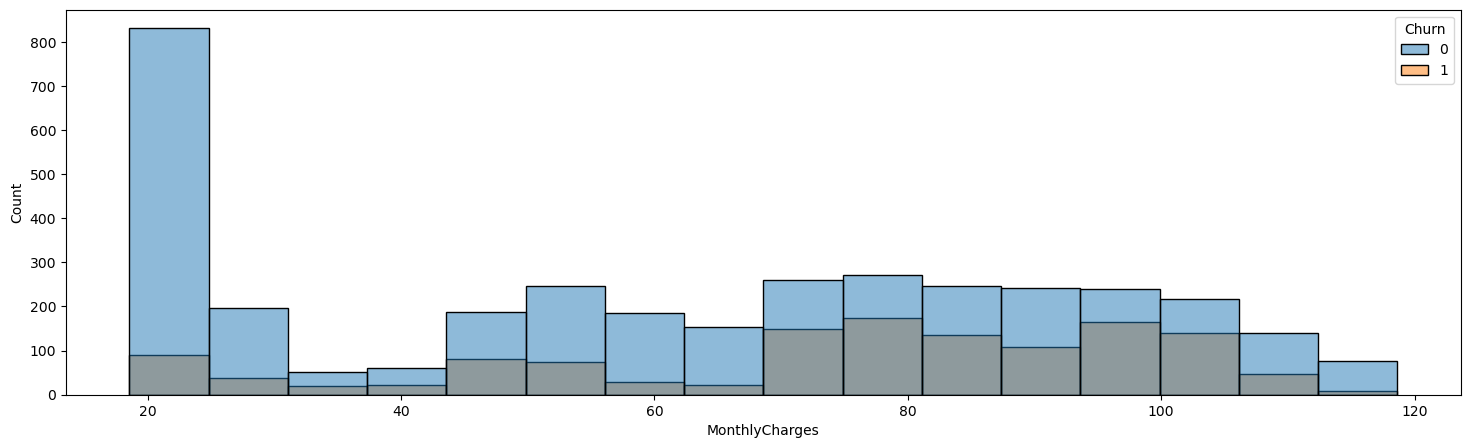

In [353]:
plt.figure(figsize=(18,5))
sns.histplot(train_data,x="MonthlyCharges",hue="Churn")

In [354]:
train_data=train_data.with_columns(train_data["MonthlyCharges"].is_between(70,110).cast(pl.Int8).alias("MonthlyChargesBin"))
test_data=test_data.with_columns(test_data["MonthlyCharges"].is_between(70,110).cast(pl.Int8).alias("MonthlyChargesBin"))

In [355]:
train_data.write_csv("../Day4_ClassBalancing/train_featureEngineered.csv")
test_data.write_csv("../Day4_ClassBalancing/test_featureEngineered.csv")
train_data.write_csv("../Day7_AutoMl/train_featureEngineered.csv")
test_data.write_csv("../Day7_AutoMl/test_featureEngineered.csv")

In [356]:
calculate_vif(train_data,"Churn")

,variables,VIF
0,const,137.152410
7,MonthlyCharges,25.465000
4,InternetService,11.901833
8,TotalCharges,10.841003
2,tenure,9.458722


In [357]:
train_data.sample(5)

customerID,SeniorCitizen,tenure,MultipleLines,InternetService,TechSupport,Contract,MonthlyCharges,TotalCharges,Churn,StreamersWithTechSupport,Safer,Family,OnlinePayment,All,ExpectedRechargeTimes,MonthlyChargesBin
str,i8,i8,i8,i8,i8,i8,f32,f32,i8,i8,i8,i8,i8,i8,f64,i8
"""6260-XLACS""",0,4,0,2,0,12,19.700001,117.800003,0,0,0,0,0,0,0.333333,0
"""7781-EWARA""",0,70,0,1,1,12,60.349998,4138.700195,0,1,0,1,0,0,5.833333,0
"""5968-HYJRZ""",0,47,1,2,0,24,24.549999,1160.449951,0,0,0,1,0,0,1.958333,0
"""2853-CWQFQ""",0,1,0,1,1,1,59.549999,59.549999,0,1,0,0,0,0,1.0,0
"""2806-MLNTI""",1,52,1,0,0,12,105.099998,5376.399902,0,1,0,0,0,0,4.333333,1


In [358]:
ratio=len(train_data.filter(train_data["Churn"]==1))/(len(train_data))
ratio

0.2649276543713063

In [359]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler,OneHotEncoder,MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
cat_cols=[col for col in train_data.drop("customerID").columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("Churn").columns if train_data[col].dtype!= pl.String]

X_train=train_data.drop("customerID","Churn").to_pandas()
y_train=train_data["Churn"].to_pandas()
X_test=test_data.drop("customerID","Churn").to_pandas()
y_test=test_data["Churn"].to_pandas()

transformer = ColumnTransformer(
    [
        ("onehot", OneHotEncoder(handle_unknown="ignore",drop='first'), cat_cols),
        ("scaler", StandardScaler(), num_cols)
     ],
    remainder="passthrough",
)

pipe = Pipeline(
    [
        ("tranformer", transformer),
        ('select',SelectKBest(k=10)),
        ("classifier", LogisticRegression(class_weight={0:1,1:ratio*10})),
    ]
)
pipe

Pipeline(steps=[('tranformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  []),
                                                 ('scaler', StandardScaler(),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'TechSupport', 'Contract',
                                                   'MonthlyCharges',
                                                   'TotalCharges',
                                                   'StreamersWithTechSupport',
                                                   'Safer', 'Family',
                                                   'OnlinePayment', 'All',
                                                   'ExpectedRechargeTimes',
                                                   'MonthlyChargesBin'])])),
                ('select', SelectKBest()),
                ('classifier',
                 LogisticRegression(class_weight={0: 1,
                                                  1: 2.6492765437130625}))])

In [360]:
from sklearn.model_selection import cross_validate, RepeatedStratifiedKFold

# Set up the RepeatedStratifiedKFold cross-validation
rskf = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=42)

# Perform cross-validation
cv_results = cross_validate(pipe, X_train, y_train, cv=rskf, scoring=['recall', 'roc_auc'], n_jobs=-1, return_train_score=True, error_score="raise")

# Print training scores
print(f'Mean Train ROC AUC Score: {cv_results["train_roc_auc"].mean():.4f}')
print(f'Standard Deviation of Train ROC AUC Scores: {cv_results["train_roc_auc"].std():.4f}')
print(f'Mean Train Recall Score: {cv_results["train_recall"].mean():.4f}')
print(f'Standard Deviation of Train Recall Scores: {cv_results["train_recall"].std():.4f}\n')

# Print testing scores
print(f'Mean Test ROC AUC Score: {cv_results["test_roc_auc"].mean():.4f}')
print(f'Standard Deviation of Test ROC AUC Scores: {cv_results["test_roc_auc"].std():.4f}')
print(f'Mean Test Recall Score: {cv_results["test_recall"].mean():.4f}')
print(f'Standard Deviation of Test Recall Scores: {cv_results["test_recall"].std():.4f}')

Mean Train ROC AUC Score: 0.8402
Standard Deviation of Train ROC AUC Scores: 0.0036
Mean Train Recall Score: 0.7994
Standard Deviation of Train Recall Scores: 0.0086

Mean Test ROC AUC Score: 0.8374
Standard Deviation of Test ROC AUC Scores: 0.0081
Mean Test Recall Score: 0.7941
Standard Deviation of Test Recall Scores: 0.0173


In [361]:
from sklearn.metrics import accuracy_score,classification_report,roc_curve,roc_auc_score
from sklearn.model_selection import cross_val_predict
predictions_prob= cross_val_predict(pipe,X_test,y_test,method='predict_proba')
predictions=[0 if x < 0.5 else 1 for x in predictions_prob[:,1]]
print("logistic regression accuracy :",accuracy_score(y_true=y_test,y_pred=predictions))
print("auc roc",roc_auc_score(y_test,predictions))
print(classification_report(y_test,predictions))

logistic regression accuracy : 0.7537950664136622
auc roc 0.7668304724990772
              precision    recall  f1-score   support

           0       0.91      0.74      0.82      1548
           1       0.52      0.79      0.63       560

    accuracy                           0.75      2108
   macro avg       0.72      0.77      0.72      2108
weighted avg       0.81      0.75      0.77      2108



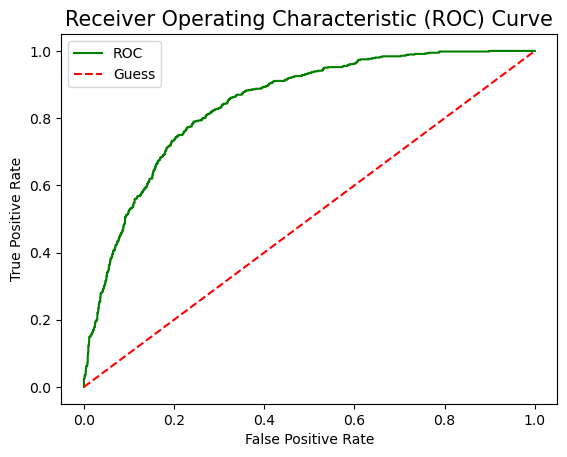

In [362]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds=roc_curve(y_test,predictions_prob[:,1])
plot_roc_curve(fpr, tpr)

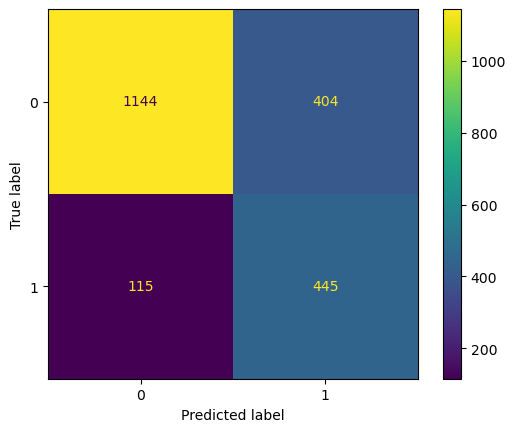

In [363]:
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix
fig=ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,predictions))
fig.plot()

In [364]:
from sklearn.metrics import roc_auc_score,f1_score,precision_score,accuracy_score,recall_score,matthews_corrcoef
# Evaluation
roc_auc = roc_auc_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
accuracy = accuracy_score(y_test, predictions)
recall = recall_score(y_test,predictions)
precision = precision_score(y_test,predictions)
coef = matthews_corrcoef(y_test,predictions)
print(f"ROC AUC: {roc_auc:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"\033[1mRecall score: {recall:.2f}\033[0m")
print(f"precision : {precision:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Corr : {coef}")

ROC AUC: 0.77
F1 Score: 0.63
Recall score: 0.79
precision : 0.52
Accuracy: 0.75
Corr : 0.4805938427377584


In [365]:
roc_auc,f1,recall,accuracy,coef

(0.7668304724990772,
 0.631653655074521,
 0.7946428571428571,
 0.7537950664136622,
 0.4805938427377584)